In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Function to fetch FPL data
def fetch_fpl_data():
    url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception("Failed to fetch data from FPL API")
    data = response.json()
    return data

# Fetch data
fpl_data = fetch_fpl_data()

# Extract necessary datasets
elements = pd.DataFrame(fpl_data['elements'])      # Player data
element_types = pd.DataFrame(fpl_data['element_types'])  # Position data
teams = pd.DataFrame(fpl_data['teams'])            # Team data

In [ ]:
# Merge elements with teams to get team names
elements = elements.merge(teams[['id', 'name']], left_on='team', right_on='id', how='left', suffixes=('', '_team'))
elements = elements.rename(columns={'name_team': 'team_name'})

# Merge elements with element_types to get position names
elements = elements.merge(element_types[['id', 'singular_name']], left_on='element_type', right_on='id', how='left', suffixes=('', '_type'))
elements = elements.rename(columns={'singular_name': 'position'})

# Select relevant features
# 'selected' column was missing from the original list
players = elements[['id', 'first_name', 'second_name', 'team_name', 'position',
                   'now_cost', 'total_points', 'selected_by_percent', 'transfers_in',
                   'transfers_out', 'minutes', 'goals_scored', 'assists',
                   'clean_sheets', 'goals_conceded', 'own_goals',
                   'yellow_cards', 'red_cards', 'saves', 'bonus']]

# Feature Engineering
players['price'] = players['now_cost'] / 10  # Convert to millions
players['cost_change'] = players['transfers_in'] - players['transfers_out']
players['goal_contribution'] = players['goals_scored'] + players['assists']
players['points_per_game'] = players['total_points'] / (players['minutes'] / 90)
players['form'] = players['points_per_game'] * players['minutes'] / 90

# Handle missing values if any
players.fillna(0, inplace=True)

# Display the first few rows
print(players.head())

KeyError: "['team_name'] not in index"

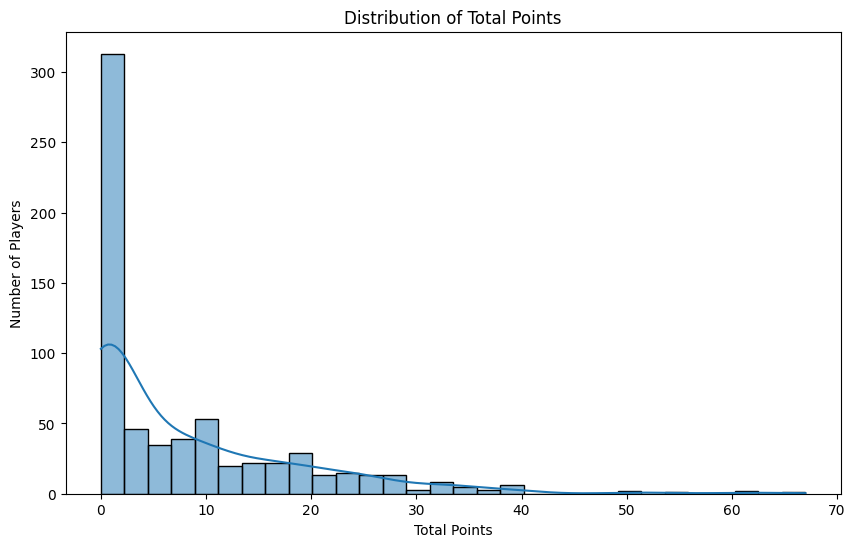

Top 10 Players by Total Points:
    first_name           second_name    team_name    team_name    position  \
413     Erling               Haaland     Man City     Man City     Forward   
389    Mohamed                 Salah    Liverpool    Liverpool  Midfielder   
205       Cole                Palmer      Chelsea      Chelsea  Midfielder   
388       Luis                  Díaz    Liverpool    Liverpool  Midfielder   
13      Bukayo                  Saka      Arsenal      Arsenal  Midfielder   
112      Bryan                Mbeumo    Brentford    Brentford  Midfielder   
262     Dwight                McNeil      Everton      Everton  Midfielder   
203    Nicolas               Jackson      Chelsea      Chelsea     Forward   
62       Ollie               Watkins  Aston Villa  Aston Villa     Forward   
2      Gabriel  dos Santos Magalhães      Arsenal      Arsenal    Defender   

       position    position  total_points  
413     Forward     Forward            67  
389  Midfielder  Midf

In [ ]:
# Distribution of total points
plt.figure(figsize=(10,6))
sns.histplot(players['total_points'], bins=30, kde=True)
plt.title('Distribution of Total Points')
plt.xlabel('Total Points')
plt.ylabel('Number of Players')
plt.show()

# Top 10 players by total points
top_players = players.sort_values(by='total_points', ascending=False).head(10)
print("Top 10 Players by Total Points:")
print(top_players[['first_name', 'second_name', 'team_name', 'position', 'total_points']])

In [ ]:
# Define target variable
target = 'total_points'

# Define feature variables
# 'selected' was replaced by 'selected_by_percent'
features = ['now_cost', 'selected_by_percent', 'transfers_in', 'transfers_out',
            'minutes', 'goals_scored', 'assists', 'clean_sheets',
            'goals_conceded', 'own_goals', 'yellow_cards', 'red_cards',
            'saves', 'bonus']

X = players[features]
y = players[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on Test Set: {mae:.2f} points")

Mean Absolute Error on Test Set: 1.36 points


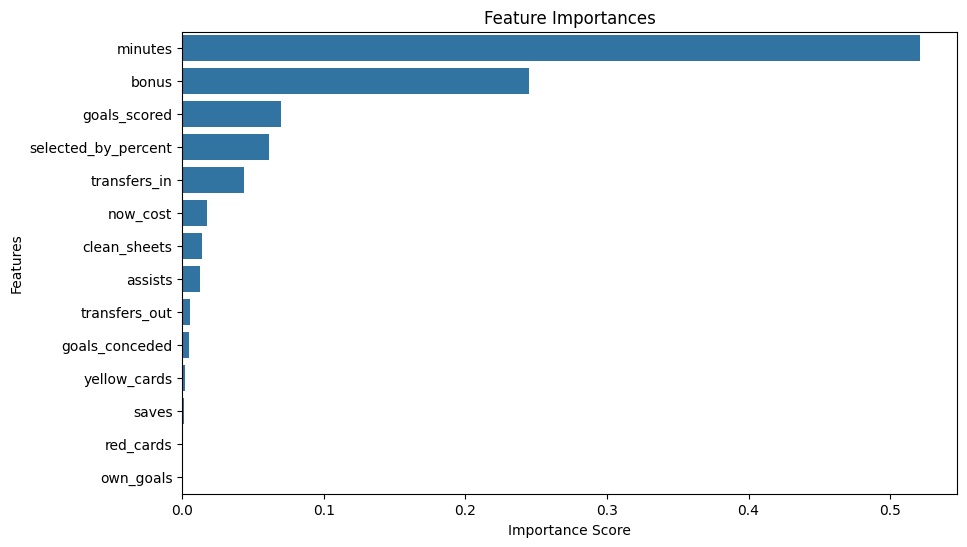

In [ ]:
# Get feature importances
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [ ]:
# Predict points for all players
players['predicted_points'] = model.predict(players[features])

# Display top 20 predicted players
predicted_top_players = players.sort_values(by='predicted_points', ascending=False).head(20)
print("Top 20 Predicted Players:")
print(predicted_top_players[['first_name', 'second_name', 'team_name', 'position', 'predicted_points']])

Top 20 Predicted Players:
    first_name           second_name      team_name      team_name  \
413     Erling               Haaland       Man City       Man City   
389    Mohamed                 Salah      Liverpool      Liverpool   
205       Cole                Palmer        Chelsea        Chelsea   
388       Luis                  Díaz      Liverpool      Liverpool   
13      Bukayo                  Saka        Arsenal        Arsenal   
112      Bryan                Mbeumo      Brentford      Brentford   
62       Ollie               Watkins    Aston Villa    Aston Villa   
203    Nicolas               Jackson        Chelsea        Chelsea   
278      Emile            Smith Rowe         Fulham         Fulham   
2      Gabriel  dos Santos Magalhães        Arsenal        Arsenal   
3          Kai               Havertz        Arsenal        Arsenal   
262     Dwight                McNeil        Everton        Everton   
373      Trent      Alexander-Arnold      Liverpool      Liverpo

In [ ]:
# Install PuLP if not already installed
!pip install pulp

import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpBinary, LpStatus

# Drop duplicate columns in the DataFrame
opt_df = opt_df.loc[:, ~opt_df.columns.duplicated()]

# Initialize the optimization problem
prob = LpProblem("FPL_TEAM_SELECTION", LpMaximize)

# Define decision variables
player_vars = LpVariable.dicts("Players", opt_df.index, cat=LpBinary)

# Objective: Maximize total predicted points
prob += lpSum([opt_df.loc[i, 'predicted_points'] * player_vars[i] for i in opt_df.index])

# Budget constraint
prob += lpSum([opt_df.loc[i, 'cost'] * player_vars[i] for i in opt_df.index]) <= BUDGET

# Position constraints
for position, required in required_positions.items():
    prob += lpSum([player_vars[i] for i in opt_df.index if opt_df.loc[i, 'position'] == position]) == required

# Team constraints
teams_unique = opt_df['team_name'].unique()
for team in teams_unique:
    prob += lpSum([player_vars[i] for i in opt_df.index if opt_df.loc[i, 'team_name'] == team]) <= max_players_per_team

# Total players constraint
prob += lpSum([player_vars[i] for i in opt_df.index]) == sum(required_positions.values())

# Solve the problem
prob.solve()

# Check if the solution is optimal
print(f"Status: {LpStatus[prob.status]}")

# Get selected players
selected_players = []
for i in opt_df.index:
    if player_vars[i].varValue == 1:
        selected_players.append(opt_df.loc[i])

selected_team = pd.DataFrame(selected_players)

print("\nOptimal Team Selection:")
print(selected_team[['first_name', 'second_name', 'team_name', 'position', 'cost', 'predicted_points']])

# Calculate total cost and points
total_cost = selected_team['cost'].sum()
total_points = selected_team['predicted_points'].sum()
print(f"\nTotal Cost: {total_cost} million")
print(f"Total Predicted Points: {total_points:.2f}")


Status: Optimal

Optimal Team Selection:
    first_name           second_name    team_name    position  cost  \
2      Gabriel  dos Santos Magalhães      Arsenal    Defender   6.2   
11       David           Raya Martin      Arsenal  Goalkeeper   5.6   
62       Ollie               Watkins  Aston Villa     Forward   9.1   
112      Bryan                Mbeumo    Brentford  Midfielder   7.4   
166      Danny               Welbeck     Brighton     Forward   5.8   
203    Nicolas               Jackson      Chelsea     Forward   7.9   
205       Cole                Palmer      Chelsea  Midfielder  10.7   
208     Robert               Sánchez      Chelsea  Goalkeeper   4.7   
262     Dwight                McNeil      Everton  Midfielder   5.6   
278      Emile            Smith Rowe       Fulham  Midfielder   5.8   
373      Trent      Alexander-Arnold    Liverpool    Defender   7.1   
387   Ibrahima                Konaté    Liverpool    Defender   5.2   
388       Luis                  Díaz

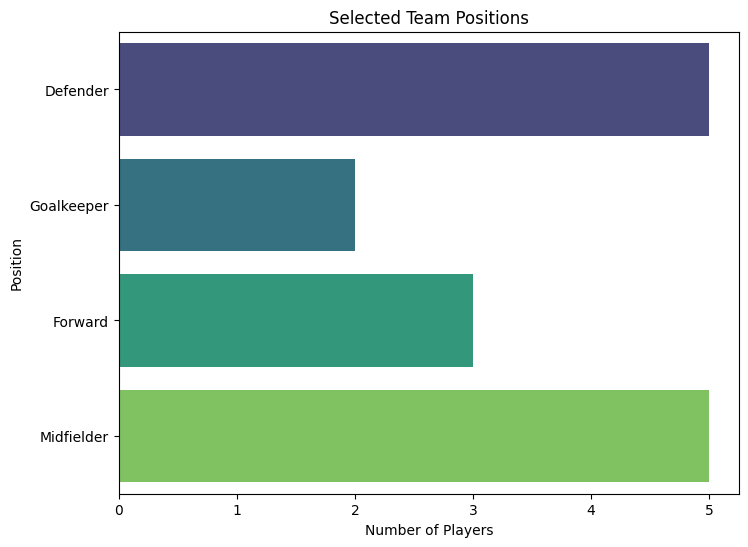

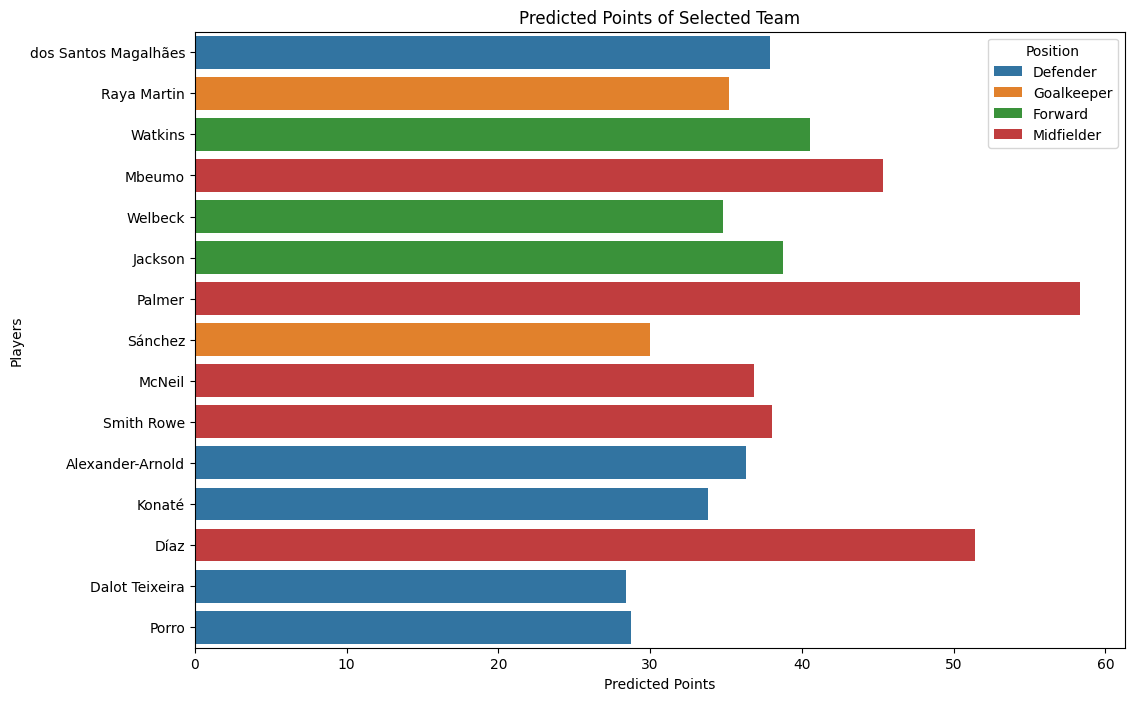

In [ ]:
# Distribution of positions in the selected team
plt.figure(figsize=(8,6))
sns.countplot(data=selected_team, y='position', palette='viridis')
plt.title('Selected Team Positions')
plt.xlabel('Number of Players')
plt.ylabel('Position')
plt.show()

# Bar chart of predicted points
plt.figure(figsize=(12,8))
sns.barplot(data=selected_team, x='predicted_points', y='second_name', hue='position')
plt.title('Predicted Points of Selected Team')
plt.xlabel('Predicted Points')
plt.ylabel('Players')
plt.legend(title='Position')
plt.show()

In [1]:
from google.colab import auth
auth.authenticate_user()


In [4]:
!git config --global user.name "YassineEssghaier"
!git config --global user.email "yassine.essghaier14@gmail.com"



In [5]:
!git clone https://github.com/YassineEssghaier/Fantasy-FPL-Predictions-and-Data-Analysis


Cloning into 'Fantasy-FPL-Predictions-and-Data-Analysis'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [15]:
!mv *.ipynb Fantasy-FPL-Predictions-and-Data-Analysis/


mv: cannot stat '*.ipynb': No such file or directory
